In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp

In [4]:
users = pd.read_csv('/content/drive/MyDrive/ml-1m/users.dat', sep='::',engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip'])

ratings = pd.read_csv('/content/drive/MyDrive/ml-1m/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])

movies = pd.read_csv('/content/drive/MyDrive/ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)

In [5]:
movies.genre = movies.genre.apply(
    lambda x: x.split('|')
)
genres = set()
for genre_list in movies['genre']:
    genres.update(genre_list)
genres = sorted(list(genres))
genre_dict = {genres[i]: i for i in range(len(genres))}

def convert(genres):
  ret = []
  for genre in genres:
    ret.append(genre_dict[genre])

  return ret

movies['genre_id'] = movies.genre.apply(
    lambda x: convert(x)
)

In [6]:
pd_dict = {'label': genre_dict.values(), 'genre': genre_dict.keys()}
pd_dict = pd.DataFrame.from_dict(pd_dict)
# pd_dict.to_csv('genre_dict.txt', sep='\t', header=False, index=False)

In [7]:
mintime = min(ratings.timestamp)
maxtime = max(ratings.timestamp)

In [8]:
movies_list = [movie for movie in ratings.movieid.unique() if len(ratings[ratings.movieid == movie].userid.unique()) >= 5]
ratings = ratings[ratings.movieid.isin(movies_list)]

top_users = ratings.userid.value_counts().nlargest(1000)
ratings = ratings[ratings.userid.isin(top_users.index)]

In [9]:
le_user = le_item = LabelEncoder()
le_user.fit(ratings.userid.to_numpy())
ratings.userid = le_user.transform(ratings.userid)

le_item.fit(ratings.movieid.to_numpy())
ratings.movieid = le_item.transform(ratings.movieid)

In [10]:
ratings['fav'] = ratings.rating.apply(
    lambda x: 1 if x > 3 else 0
)

In [ ]:
# user_list = ratings.userid.unique()
# ui = {}

# with open('user_item.txt', 'w') as f:
#   for user in tqdm(user_list):
#     movie_list = ratings[(ratings.userid == user)].movieid.unique()
#     ui[user] = movie_list
#     for movie in movie_list:
#       f.write(f'{user}\t{movie}\n')

In [ ]:
# mintime = min(ratings.timestamp)
# maxtime = max(ratings.timestamp)
# ratings['timestamp_norm'] = ratings.timestamp.apply(
#     lambda x: x - mintime
# )

In [ ]:
# year_time = 365 * 24 * 60 * 60
# month_time = 30 * 24 * 60 * 60
# week_time = 7 * 24 * 60 * 60
# three_day = 3 * 24 * 60 * 60
# one_day = 24 * 60 * 60

# ratings['year'] = ratings.timestamp_norm.apply(
#     lambda x: int(x/year_time) + 1
# )
# ratings['month'] = ratings.timestamp_norm.apply(
#     lambda x: int(x/month_time) + 1
# )
# ratings['week'] = ratings.timestamp_norm.apply(
#     lambda x: int(x/week_time) + 1
# )
# ratings['three_days'] = ratings.timestamp_norm.apply(
#     lambda x: int(x/three_day) + 1
# )
# ratings['one_day'] = ratings.timestamp_norm.apply(
#     lambda x: int(x/one_day) + 1
# )

In [11]:
for genre in genres:
    movies[genre] = 0

for index, row in movies.iterrows():
    for genre in row['genre']:
        movies.at[index, genre] = 1
    for genre in genres:
        if genre not in row['genre']:
            movies.at[index, genre] = 0

# movies = movies.drop(columns=['genre'])
ratings = pd.merge(ratings, movies, how='left', left_on='movieid', right_on='movieid')
ratings.dropna(inplace=True)

In [ ]:
# rating_cnt = {}
# for x in ratings.rating.tolist():
#   if x not in rating_cnt:
#     rating_cnt[x] = 1
#   else:
#     rating_cnt[x] += 1

# plt.figure(figsize=(14, 8))
# plt.bar(rating_cnt.keys(), rating_cnt.values(), color='skyblue', width=0.6)
# plt.xlabel('Rating')
# plt.ylabel('Times')
# plt.title('Rating Distribution')

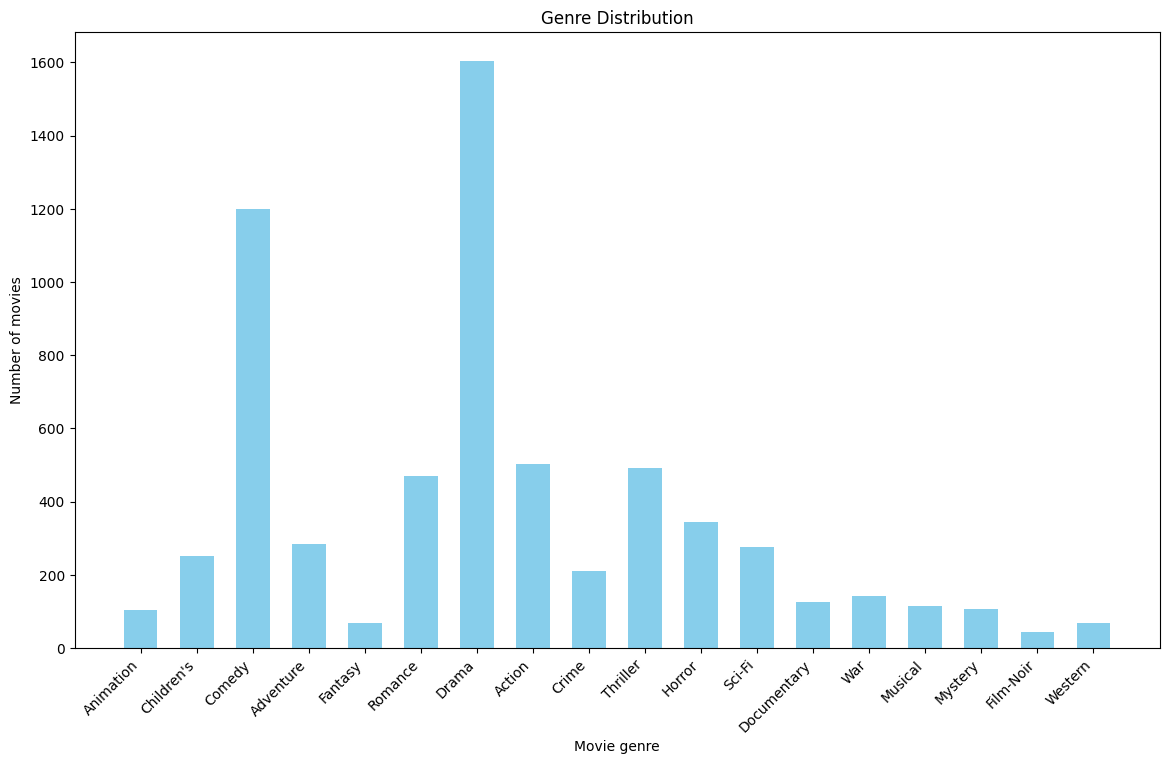

In [12]:
genre_cnt = {}

for gens in movies.genre.tolist():
  for x in gens:
    if x in genre_cnt:
      genre_cnt[x] += 1
    else:
      genre_cnt[x] = 1

plt.figure(figsize=(14, 8))
plt.bar(genre_cnt.keys(), genre_cnt.values(), color='skyblue', width=0.6)
plt.xlabel('Movie genre')
plt.ylabel('Number of movies')
plt.title('Genre Distribution')

plt.xticks(rotation=45, ha='right')

plt.show()

In [13]:
ratings = ratings.sort_values(by=['userid', 'timestamp'])

In [14]:
user_list = ratings.userid.unique()
ui = {}

with open('user_item.txt', 'w') as f:
  for user in tqdm(user_list):
    movie_list = ratings[(ratings.userid == user)].movieid.unique()
    movie_list = sorted(movie_list)
    ui[user] = movie_list
    for movie in movie_list:
      # list_genre = ratings[ratings.movieid==movie].genre_id.tolist()[0]

      # out = f'{user}\t{movie}\t{list_genre[0]}\n'
      # for x in list_genre:
        # out += str(x) + '\t'
      # out += '\n'
      # f.write(out)
      f.write(f'{user}\t{movie}\n')

100%|██████████| 1000/1000 [00:02<00:00, 454.97it/s]


In [39]:
import random
bundle_dict = {}
user_bundle = {}
user_list = ratings.userid.unique()
bundle_cate = {x: [] for x in range(18)}
bundle_item = {}

with open('bundle_item.txt', 'w') as f2, open('user_bundle_train.txt', 'w') as f3, open('user_bundle_tune.txt', 'w') as f4, open('user_bundle_test.txt', 'w') as f5:
  for user in tqdm(user_list):
    bundles = []
    # for week in new_ratings[new_ratings.useridn == user].week.unique():
    for genre in genre_dict.keys():
      bundle = ratings[(ratings.userid == user) & (ratings[genre] == 1)].movieid.unique()
    # bundle = ratings[(ratings.userid == user) & (ratings.fav == 1)].movieid.unique()
      bundle.sort()

      if 2 <= len(bundle) <= 5:
        bundle = tuple(bundle)
        if bundle not in bundle_dict:
          bundle_dict[bundle] = len(bundle_dict)
          bundle_cate[genre_dict[genre]].append(bundle_dict[bundle])
          for item in bundle:
            f2.write(f'{bundle_dict[bundle]}\t{item}\n')
          bundle_item[bundle_dict[bundle]] = bundle
          bundles.append(bundle_dict[bundle])
      # elif 10 < len(bundle) < 20:
      #   for i in range(0, len(bundle), 10):
      #     tmp_bun = tuple(bundle[i:i+10])
      #     if len(tmp_bun) >= 5 and tmp_bun not in bundle_dict:
      #       bundle_dict[tmp_bun] = len(bundle_dict)
      #       for item in tmp_bun:
      #         f2.write(f'{bundle_dict[tmp_bun]}\t{item}\n')
      #       bundle_cate[genre_dict[genre]].append(bundle_dict[tmp_bun])
      #       bundles.append(bundle_dict[tmp_bun])

    user_bundle[user] = bundles
    for bundle in bundles[:int(0.6*len(bundles))]:
      f3.write(f'{user}\t{bundle}\n')

    for bundle in bundles[int(0.6*len(bundles)):int(0.8*len(bundles))]:
      f4.write(f'{user}\t{bundle}\n')

    for bundle in bundles[int(0.8*len(bundles)):]:
      f5.write(f'{user}\t{bundle}\n')

100%|██████████| 1000/1000 [00:42<00:00, 23.60it/s]


In [40]:
len(bundle_dict)

1151

In [41]:
with open('ML1M_data_size.txt', 'w') as f:
  f.write(f'{len(user_list)}\t{len(bundle_dict)}\t{len(movies_list)}')

In [42]:
import os

out_path = '/content'

with open(os.path.join(out_path, 'ML1M_data_size.txt'), 'r') as f:
    num_users, num_bundles, num_items = map(int, f.readline().split('\t'))

def get_ui():
    with open(os.path.join(out_path, 'user_item.txt'), 'r') as f:
        ui_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

    indices = np.array(ui_pairs, dtype=np.int32)
    values = np.ones(len(ui_pairs))
    ui_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(num_users, num_items)).tocsr()

    return ui_pairs, ui_graph

def get_bi():
    with open(os.path.join(out_path, 'bundle_item.txt'), 'r') as f:
        bi_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

    indices = np.array(bi_pairs, dtype=np.int32)
    values = np.ones(len(bi_pairs))
    bi_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(num_bundles, num_items)).tocsr()

    return bi_graph

def get_ub(task):
  with open(os.path.join(out_path, f'user_bundle_{task}.txt'), 'r') as f:
    ub_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

  indices = np.array(ub_pairs, dtype=np.int32)
  values = np.ones(len(ub_pairs))
  ub_graph = sp.coo_matrix((values, (indices[:, 0], indices[:, 1])), shape=(num_users, num_bundles)).tocsr()

  return ub_graph


In [44]:
_, ui_graph = get_ui()
ub_train = get_ub('train')
ub_tune = get_ub('tune')
ub_test = get_ub('test')

In [20]:
item_pop = ui_graph.sum(axis=0)
_, cold_item_idx = np.where(item_pop < 2)
cold_items = np.array(cold_item_idx).squeeze()
item_pop = np.array(item_pop).squeeze()

In [22]:
import random
random.seed(2024)

training_data=[]
cold_tune_data=[]
cold_test_data=[]
bundle_set=set()
for user,bundles in user_bundle.items():
    bundles = list(bundles)
    random.shuffle(bundles)
    len_bundles=len(bundles)
    train, tune, test = [], [], []

    tmp = []
    if len(bundles) > 2:
      for i, bundle in enumerate(bundles):
          is_train, is_test=False, False

          if len(np.intersect1d(list(bundle_item[bundle]), cold_items)) > 0 or len(train) < int(0.7 * len_bundles):
              train.append((user,bundle))
          elif len(np.intersect1d(list(bundle_item[bundle]), cold_items)) <= 0:
              tmp.append((user,bundle))
    else:
      for i, bundle in enumerate(bundles):
        train.append((user,bundle))

    training_data.extend(train)
    cold_tune_data.extend(tmp[:int(len(tmp)/2)])
    cold_test_data.extend(tmp[int(len(tmp)/2):])

In [26]:
print(len(training_data))
print(len(cold_tune_data))
print(len(cold_test_data))

989
26
136


In [45]:
cold_tune_bun = list(dict.fromkeys([y for x, y in cold_tune_data]))
cold_test_bun = list(dict.fromkeys([y for x, y in cold_tune_data]))

cold_train_bun = list(dict.fromkeys([y for x, y in training_data if y not in cold_tune_bun and y not in cold_test_bun]))

In [46]:
bundle_pop = ub_tune.sum(axis=0)
new_training_data=[]

for x, y in training_data:
  if y in cold_tune_bun or y in cold_test_bun:
    pop = bundle_pop[y]
    while pop > 0:
      ran_num = random.randint(0, len(cold_train_bun))
      new_training_data.append((x, cold_train_bun[ran_num]))
      pop -= 1
  else:
    new_training_data.append((x, y))

In [47]:
training_data = np.array(new_training_data)
cold_tune_data = np.array(cold_tune_data)
cold_test_data = np.array(cold_test_data)

ub_train = pd.DataFrame(training_data,columns=['user','bundle'])
ub_tune = pd.DataFrame(cold_tune_data,columns=['user','bundle'])
ub_test = pd.DataFrame(cold_test_data,columns=['user','bundle'])

ub_train.to_csv(f'{out_path}/user_bundle_train.txt', sep='\t', header=False, index=False)
ub_tune.to_csv(f'{out_path}/user_bundle_tune.txt', sep='\t', header=False, index=False)
ub_test.to_csv(f'{out_path}/user_bundle_test.txt', sep='\t', header=False, index=False)

In [55]:
ub_train = get_ub('train')
ub_tune = get_ub('tune')
ub_test = get_ub('test')

In [58]:
np.array(ub_train.sum(axis=0)).squeeze()[ub_test.nonzero()[1]].sum()

0.0

In [ ]:
item_pop = ui_graph.sum(axis=0)
_, warm_item_idx = np.where(item_pop >= 500)

warm_items = np.array(warm_item_idx).squeeze()

In [ ]:
len(warm_items)

178

In [ ]:
import random
random.seed(2024)

warm_train_data=[]
warm_tune_data=[]
warm_test_data=[]
bundle_set=set()
for user,bundles in user_bundle.items():
    bundles = list(bundles)
    random.shuffle(bundles)
    len_bundles=len(bundles)
    train, test = [], []

    if len(bundles) > 2:
      for i, bundle in enumerate(bundles):
          is_train, is_test=False, False

          if len(np.intersect1d(list(bundle_item[bundle]), warm_items)) > 1 and len(train) < int(0.7 * len_bundles):
              train.append((user,bundle))
          # elif len(np.intersect1d(list(bundle_item_map[bundle]), warm_items)) <= 0:
          else:
              test.append((user,bundle))
    else:
      for i, bundle in enumerate(bundles):
        train.append((user,bundle))

    warm_train_data.extend(train)
    warm_tune_data.extend(test[:int(len(test)/2)])
    warm_test_data.extend(test[int(len(test)/2):])

In [ ]:
print(len(warm_train_data))
print(len(warm_tune_data))
print(len(warm_test_data))

853
107
191


In [ ]:
warm_train_data[:5]

[(0, 0), (1, 1), (1, 2), (5, 9), (6, 10)]

In [ ]:
warm_train_data = np.array(warm_train_data)
warm_tune_data = np.array(warm_tune_data)
warm_test_data = np.array(warm_test_data)

ub_train = pd.DataFrame(warm_train_data,columns=['user','bundle'])
ub_tune = pd.DataFrame(warm_tune_data,columns=['user','bundle'])
ub_test = pd.DataFrame(warm_test_data,columns=['user','bundle'])

ub_train.to_csv('user_bundle_train.txt', sep='\t', header=False, index=False)
ub_tune.to_csv('user_bundle_tune.txt', sep='\t', header=False, index=False)
ub_test.to_csv('user_bundle_test.txt', sep='\t', header=False, index=False)

In [ ]:

import shutil

# %cd /content/
# !cp -r /content/MultiCBR/datasets/ML1M /content/
shutil.make_archive('ML1Mcate', 'zip', '/content/ML1Mcate')

In [ ]:
%cd ..

In [ ]:
!mkdir data
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
from sklearn.preprocessing import LabelEncoder

bi = pd.read_csv('bundle_item.txt', sep="\t", names=['b', 'i'])
ui = pd.read_csv('user_item.txt', sep="\t", names=['u', 'i'])
ub_train = pd.read_csv('user_bundle_train.txt', sep="\t", names=['u', 'b'])
ub_test = pd.read_csv('user_bundle_test.txt', sep="\t", names=['u', 'b'])
ub_valid = pd.read_csv('user_bundle_tune.txt', sep="\t", names=['u', 'b'])

num_u = ui['u'].nunique()
num_b = bi['b'].nunique()
num_i = bi['i'].nunique()
num_iu = ui['i'].nunique()
bi_idx = bi.to_numpy()
bi_graph = torch.sparse_coo_tensor(
    indices=torch.tensor([bi_idx[:, 0], bi_idx[:, 1]]),
    values=np.ones(len(bi)),
    size=(num_b, num_iu),
)
intersect = bi_graph @ bi_graph.T
mask = torch.eye(num_b)

total_item = bi_graph.sum(dim=1)
total_item = total_item.to_dense()
total_item_a = total_item.view(-1, 1)
total_item_b = total_item.view(1, -1)

total_overlap = total_item_a + total_item_b
inter_non_eye = intersect - intersect * mask
total_overlap_non_eye = total_overlap - total_overlap * mask + mask
total_not_overlap = total_overlap_non_eye - inter_non_eye
jaccard_pair_bundle = inter_non_eye.to_dense() / total_not_overlap
eli = (jaccard_pair_bundle >= 0.5).nonzero()
eli_unique = eli[:, 0].unique()
ub = pd.concat([ub_train, ub_test, ub_valid])
bi_fil = bi[~bi['b'].isin(eli_unique.tolist())]
ub_train_fil = ub_train[~ub_train['b'].isin(eli_unique.tolist())]
ub_test_fil = ub_test[~ub_test['b'].isin(eli_unique.tolist())]
ub_valid_fil = ub_valid[~ub_valid['b'].isin(eli_unique.tolist())]
ub_all  = pd.concat([ub_train_fil, ub_test_fil, ub_valid_fil])
ub_all = ub_all.sample(frac=1)
train_idx = int(len(ub_all) * 0.7)
valid_idx = int(len(ub_all) * 0.8)
ub_train_fil = ub_all[:train_idx]
ub_valid_fil = ub_all[train_idx:valid_idx]
ub_test_fil = ub_all[valid_idx:]
ub_train_fil.to_csv("data/user_bundle_train.txt", sep="\t", index=False, header=False)
ub_test_fil.to_csv("data/user_bundle_test.txt", sep="\t", index=False, header=False)
ub_valid_fil.to_csv("data/user_bundle_valid.txt", sep="\t", index=False, header=False)
bi_fil.to_csv("data/bundle_item.txt", sep="\t", index=False, header=False)

mkdir: cannot create directory ‘data’: File exists


In [ ]:
len(eli_unique)

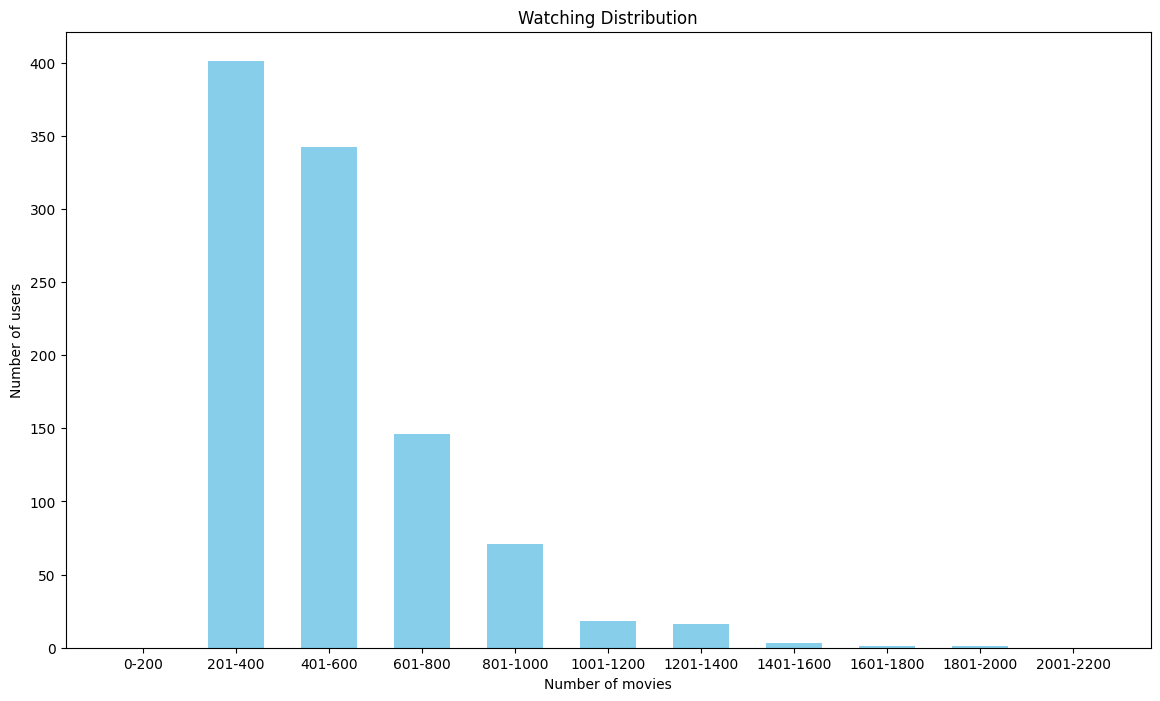

In [ ]:
# ui_ = {item: 0 for item in ratings.movieid.unique()}
# for item in ratings.movieid.unique():
#   for user in user_list:
#     if item in ui[user]:
#       ui_[item] += 1

# plt.figure(figsize=(18, 10))
# plt.bar(ui_.keys(), ui_.values())
# plt.xlabel('Number of interactions of a movie')
# plt.ylabel('Number of movies')
# plt.show()
index_ranges = [(0, 200), (201, 400), (401, 600), (601, 800), (801, 1000), (1001, 1200), (1201, 1400), (1401, 1600), (1601, 1800), (1801, 2000), (2001, 2200)]
movies_cnt = [0] * len(index_ranges)
for user, item in ui.items():
    for i, (start, end) in enumerate(index_ranges):
        if start <= len(item) <= end:
            movies_cnt[i] += 1
            break

x_labels = [f"{start}-{end}" for start, end in index_ranges]

plt.figure(figsize=(14, 8))
plt.bar(x_labels, movies_cnt, color='skyblue', width=0.6)
plt.xlabel('Number of movies')
plt.ylabel('Number of users')
plt.title('Watching Distribution')
plt.show()

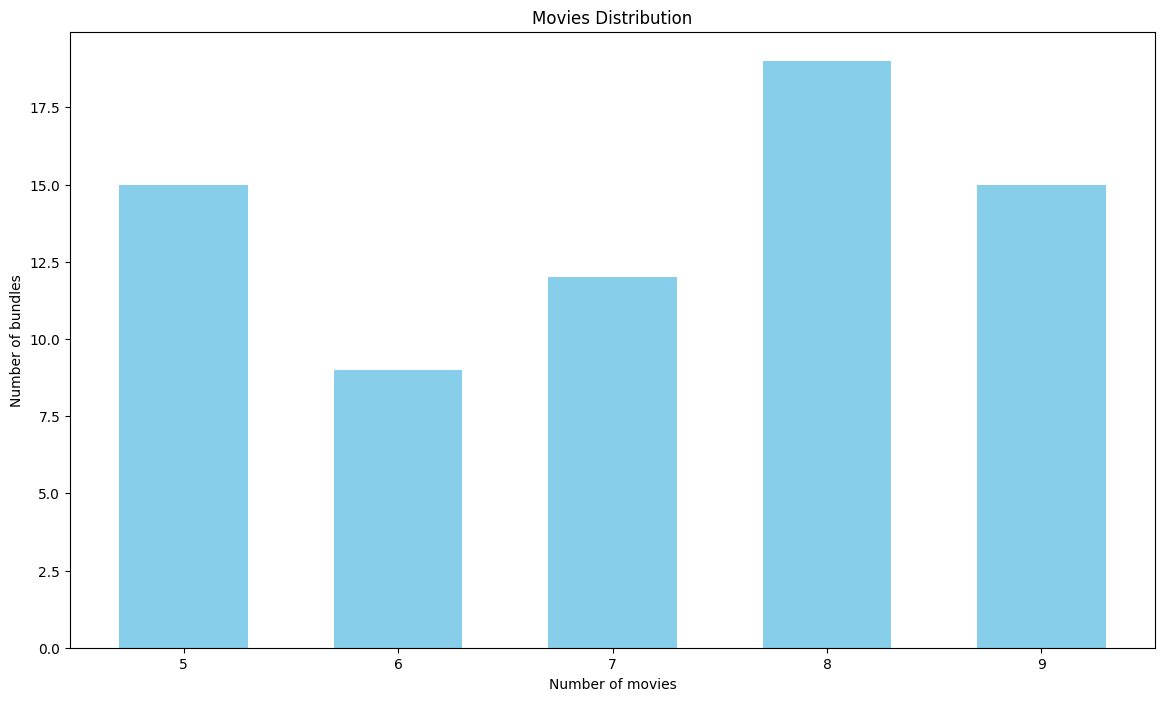

In [ ]:
# bi_dict = {}

# for b, idx in bundle_dict.items():
#   if len(b) not in bi_dict:
#     bi_dict[len(b)] = 0
#   else:
#     bi_dict[len(b)] += 1

# plt.figure(figsize=(18, 10))
# plt.bar(bi_dict.keys(), bi_dict.values())
# plt.xlabel('Number of items in a bundle')
# plt.ylabel('Number of bundles')
# plt.show()
index_ranges = [x for x in range(5, 10)]
movies_cnt = [0] * len(index_ranges)
for bun, idx in bundle_dict.items():
    for i, x in enumerate(index_ranges):
        if len(bun) == x:
            movies_cnt[i] += 1
            break

x_labels = [x for x in index_ranges]

plt.figure(figsize=(14, 8))
plt.bar(x_labels, movies_cnt, color='skyblue', width=0.6)
plt.xlabel('Number of movies')
plt.ylabel('Number of bundles')
plt.title('Movies Distribution')
plt.show()

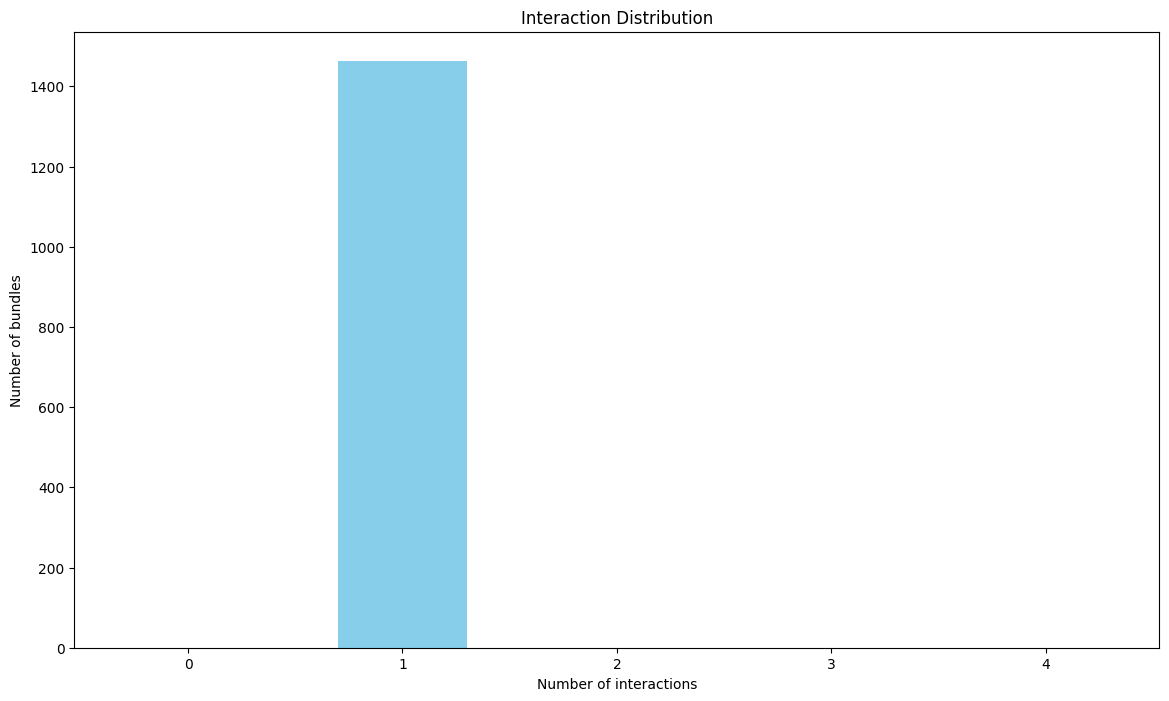

In [ ]:
# ub_dict = {}
# for u, b in user_bundle.items():
#   if len(b) not in ub_dict:
#     ub_dict[len(b)] = 1
#   else:
#     ub_dict[len(b)] += 1

# plt.figure(figsize=(18, 10))
# plt.bar(ub_dict.keys(), ub_dict.values())
# plt.xlabel('Number of bundles an user watched')
# plt.ylabel('Number of users')
# plt.show()
buns = [0] * len(bundle_dict)
for user, bun in user_bundle.items():
  for x in bun:
    buns[x] += 1

x_labels = [x for x in range(5)]
bun_cnt = [0] * 5
for i, x in enumerate(buns):
  for idx, cnt in enumerate(x_labels):
    if x == cnt:
      bun_cnt[idx] += 1
      break

plt.figure(figsize=(14, 8))
plt.bar(x_labels, bun_cnt, color='skyblue', width=0.6)
plt.xlabel('Number of interactions')
plt.ylabel('Number of bundles')
plt.title('Interaction Distribution')
plt.show()

In [ ]:
bun_cnt

[0, 1463, 0, 0, 0]

In [ ]:
bu_dict = {}

for b, idx in bundle_dict.items():
  for user in user_list:
    if idx not in user_bundle[user]:
      bu_dict[idx] = 1
    else:
      bu_dict[idx] += 1

bun_interact = {}
for bun, cnt in bu_dict.items():
  if cnt not in bun_interact:
    bun_interact[cnt] = 1
  else:
    bun_interact[cnt] += 1

plt.figure(figsize=(18, 10))
plt.bar(bun_interact.keys(), bun_interact.values())
plt.xlabel('Number of times a bundle has been watched')
plt.ylabel('Number of bundles')
plt.show()

In [ ]:
# norm = movies.movieid_norm.unique()
# with open('/content/drive/MyDrive/ml-1m/movieid_lookup.txt', 'w') as f:
#   for id in tqdm(norm):
#     f.write(f'{id}\t{movies[movies.movieid_norm==id].movieid}\n')


100%|██████████| 3883/3883 [00:02<00:00, 1456.79it/s]


In [ ]:
import scipy.sparse as sp

def get_data_size():
  with open('MLcate_data_size.txt', 'r') as f:
    return [int(i) for i in f.readline().split('\t')][:4]

def get_uic():
  ui_pairs = []
  ic_pairs = []
  with open('user_item.txt', 'r') as f:
      while True:
          line = f.readline()
          if not line:
              break
          g = line.split("\t")[:-1]
          g_ = [int(i) for i in g]
          u, i, cates = g_[0], g_[1], g_[2:]
          ui_pairs.append([u, i])
          for cate in cates:
              ic_pairs.append([i, cate])
  ui_indice = np.array(ui_pairs, dtype=np.int32)
  ic_indice = np.array(ic_pairs)
  ui_values = np.ones(len(ui_pairs), dtype=np.float32)
  ic_values = np.ones(len(ic_pairs), dtype=np.float32)

  ui_graph = sp.coo_matrix(
      (ui_values, (ui_indice[:, 0], ui_indice[:, 1])),
      shape=(num_users, num_items)
  ).tocsr()

  ic_graph = sp.coo_matrix(
      (ic_values, (ic_indice[:, 0], ic_indice[:, 1])),
      shape=(num_items, num_cates)
  ).tocsr()

  # print_statistics(ui_graph, "U-I statistics")

  return ui_pairs, ui_graph, ic_pairs, ic_graph

In [ ]:
num_users, num_bundles, num_items, num_cates = get_data_size()
ui_pairs, ui_graph, ic_pairs, ic_graph = get_uic()
uc_graph = ui_graph @ ic_graph

In [ ]:
total_cate = uc_graph.sum(axis=1) + 1e-8
uc_graph_avg = sp.diags(1/total_cate.A.ravel()) @ uc_graph

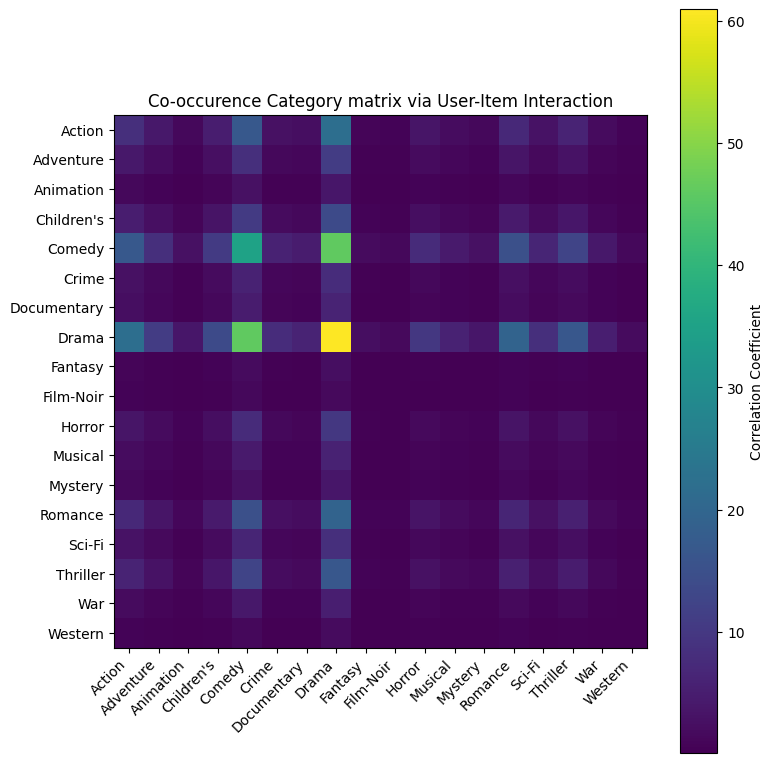

In [ ]:
cate_corr = uc_graph_avg.T @ uc_graph_avg
cate_dict = pd.read_csv('genre_dict.txt', sep='\t', names=['label', 'genre'])
cates = cate_dict.genre.tolist()

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xticks(np.arange(len(cates)))
ax.set_yticks(np.arange(len(cates)))
ax.set_xticklabels(cates, rotation=45, ha='right')
ax.set_yticklabels(cates)

cmap = plt.cm.viridis
heatmap = ax.imshow(cate_corr.todense(), cmap=cmap)

plt.colorbar(heatmap, label='Correlation Coefficient')

plt.title('Co-occurence Category matrix via User-Item Interaction')
plt.tight_layout()
plt.show()

In [ ]:
uc_dense = uc_graph.toarray()
uc_count = (uc_dense > 0).sum(axis=1)

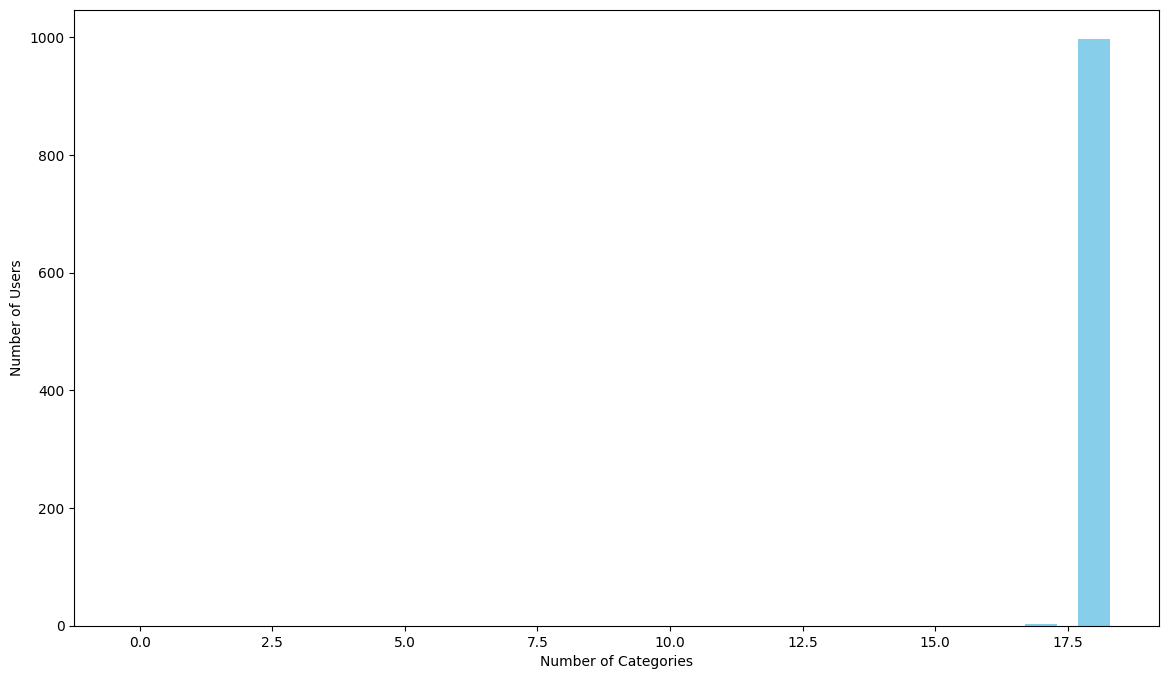

In [ ]:
user_cate = [0] * 19
for x in uc_count:
  user_cate[x] += 1

x_labels = [x for x in range(19)]

plt.figure(figsize=(14,8))

plt.bar(x_labels, user_cate, color='skyblue', width=0.6)
plt.xlabel('Number of Categories')
plt.ylabel('Number of Users')

plt.show()

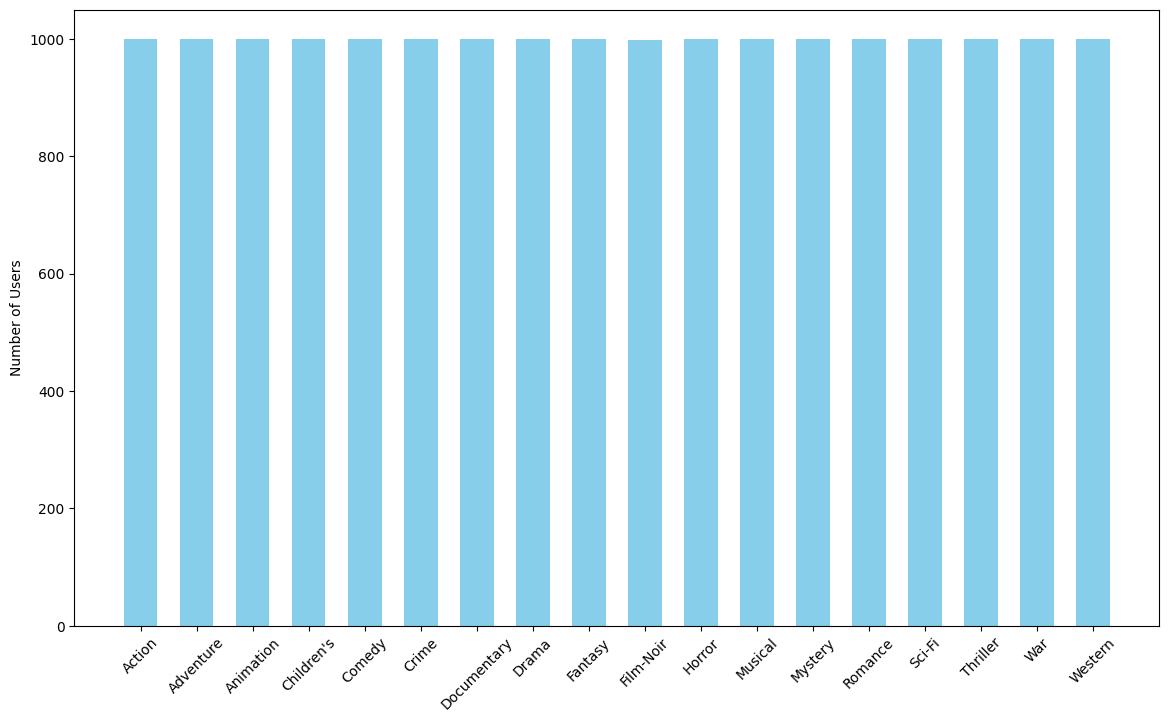

In [ ]:
cu_count = (uc_dense > 0).sum(axis=0)

plt.figure(figsize=(14,8))

plt.bar(cates, cu_count, color='skyblue', width=0.6)
# plt.set_xticklabels(rotation=45)
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()